## Problem 2.2 (Exploring fish sleep data)

In [2]:
import numpy as np
import pandas as pd
import itertools

import altair as alt
import altair_catplot as altcat

alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

Our goal for this problem is to come up with two metrics to parameterize sleep behavior using datasets that describe the movement of zebrafish larvae over time for wild type, heterozygous mutant, and homozygous mutant zebrafish.

### Tidying Data

The first step is to combine and tidy our genotype and behavioral datasets. Let's first read in the genotype dataset.

In [3]:
df_gt = pd.read_csv('../data/130315_1A_genotypes.txt',
                    delimiter='\t',
                    comment='#',
                    header=[0, 1])
# Take a look
df_gt.head()

,Genotype1,Genotype2,Genotype3
,WT 17,Het 34,Mut 22
0,2.0,1,4.0
1,14.0,3,11.0
2,18.0,5,12.0
3,24.0,6,13.0
4,28.0,8,20.0


Let's start to tidy up the data by first resetting and renaming the columns.

In [4]:
# Reset the columns to be the second level of indexing
df_gt.columns = df_gt.columns.get_level_values(1)

# Check out the new columns
df_gt.columns

Index(['WT 17', 'Het 34', 'Mut 22'], dtype='object')

In [5]:
# Rename the columns
df_gt.columns = ['wt', 'het', 'mut']

In [6]:
# Tidy the DataFrame
df_gt = pd.melt(df_gt, var_name='genotype', value_name='location')

# Take a look
df_gt.head()

,genotype,location
0,wt,2.0
1,wt,14.0
2,wt,18.0
3,wt,24.0
4,wt,28.0


We notice there are some rows with NaN values in them, so we will drop these rows.

In [7]:
# Drop all rows that have a NaN in them
df_gt = df_gt.dropna()

# Reset the index
df_gt = df_gt.reset_index(drop=True)

df_gt.head()

,genotype,location
0,wt,2.0
1,wt,14.0
2,wt,18.0
3,wt,24.0
4,wt,28.0


In [8]:
# Reset location values from floats to ints.
df_gt.loc[:,'location'] = df_gt.loc[:, 'location'].astype(int)

Now let's load in the behavioral data set to get the activity and temporal information for each location.

In [9]:
df = pd.read_csv('../data/130315_1A_aanat2.csv', comment='#')

# Take a look
df.head()

,location,activity,time,zeit,zeit_ind,day
0,1,0.6,2013-03-15 18:31:09,-14.480833,-869,4
1,2,1.4,2013-03-15 18:31:09,-14.480833,-869,4
2,3,0.0,2013-03-15 18:31:09,-14.480833,-869,4
3,4,0.0,2013-03-15 18:31:09,-14.480833,-869,4
4,5,0.0,2013-03-15 18:31:09,-14.480833,-869,4


Merge the two datasets to combine the behavioral data with the genotype data.

In [10]:
df = pd.merge(df, df_gt)

# Take a look
df.head()

,location,activity,time,zeit,zeit_ind,day,genotype
0,1,0.6,2013-03-15 18:31:09,-14.480833,-869,4,het
1,1,1.9,2013-03-15 18:32:09,-14.464167,-868,4,het
2,1,1.9,2013-03-15 18:33:09,-14.447500,-867,4,het
3,1,13.4,2013-03-15 18:34:09,-14.430833,-866,4,het
4,1,15.4,2013-03-15 18:35:09,-14.414167,-865,4,het


Now let's create a column called 'light' that will help us determine if the lights are on or off during the experiment. In this experiment, lights are turned on at 9AM and turned off at 11PM. We will set 'light' to True if the lights are on and False if the lights are off.

In [11]:
df['time'] = pd.to_datetime(df['time'])

In [12]:
df['light'] = (  (df['time'].dt.time >= pd.to_datetime('9:00:00').time())
               & (df['time'].dt.time < pd.to_datetime('23:00:00').time()))

# Take a look
df.head()

,location,activity,time,zeit,zeit_ind,day,genotype,light
0,1,0.6,2013-03-15 18:31:09,-14.480833,-869,4,het,True
1,1,1.9,2013-03-15 18:32:09,-14.464167,-868,4,het,True
2,1,1.9,2013-03-15 18:33:09,-14.447500,-867,4,het,True
3,1,13.4,2013-03-15 18:34:09,-14.430833,-866,4,het,True
4,1,15.4,2013-03-15 18:35:09,-14.414167,-865,4,het,True


## Determining sleep parameters

## First Parameter 

Now that we've cleaned up the data, let's first look at the overall activity for each genotype during the day and the night by plotting the ECDF.

In [29]:
# Make axes the same
axis_scale = alt.Scale(domain=[0, 55])

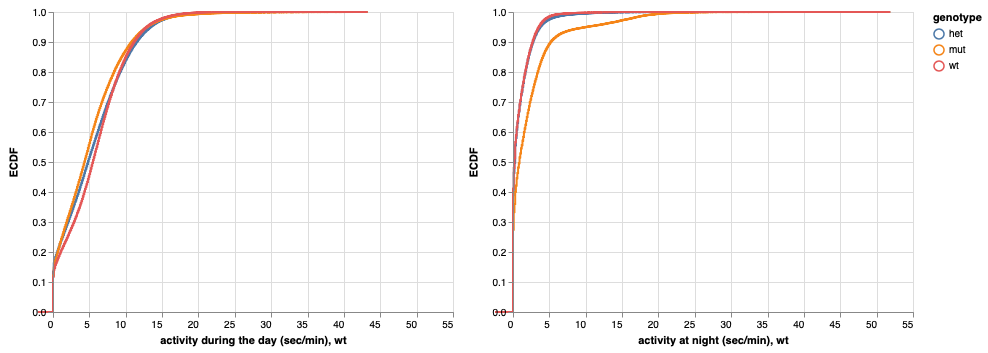

In [14]:
p1 = altcat.catplot(data=df.loc[df['light']==True, :],
                    mark='line',
                    encoding=dict(x=alt.X('activity:Q', scale=axis_scale, title='activity during the day (sec/min), wt'),
                                  color=alt.Color('genotype:N', sort=['wt', 'het', 'mut'])),
                    transform = 'ecdf')

p2 = altcat.catplot(data=df.loc[df['light']==False, :],
                    mark='line',
                    encoding=dict(x=alt.X('activity:Q', scale=axis_scale, title='activity at night (sec/min), wt'),
                                  color=alt.Color('genotype:N', sort=['wt', 'het', 'mut'])),
                    transform = 'ecdf')

p1 | p2

From these initial plots, we see that during the day, all three genotypes appear to have similar activity levels, but at night, the mutant zebrafish's activity is qualitatively different from the wild-type and heterozygous zebrafish.

We decided to look at the mean activity during the day and night on day 5 of a zebrafish's life, analyzing each fish separately. We chose the 5th day as the zebrafish's activity levels change each day as they develop, and the 5th day is the day used for analysis in Prober et. al. We are analyzing each fish's activity separately because when we plotted the activity traces for each individual fish, we saw that there appear to be two fish, in locations 21 and 67, that are up all night for some of the nights and were likely sick or died during the experiment.

First we need to group the data by location and light for day 5, taking out the sick fish. 

In [15]:
inds = ((df['day'] == 5)
       & (df['location'] != 21)
       & (df['location'] != 67))

grouped = df.loc[inds, :].groupby(['location', 'light', 'genotype'])

Now we can take the mean activity during the day and night for each fish on day 5. 

In [16]:
# Take the mean of the activity during day and night
df_mean = grouped['activity'].mean()

# Take a look
df_mean.head()

location  light  genotype
1         False  het         1.209667
          True   het         4.075866
2         False  wt          0.542500
          True   wt          6.136918
3         False  het         0.517500
Name: activity, dtype: float64

In [17]:
# Reset index 
df_mean = df_mean.reset_index()

In [18]:
# Rename the activity column to mean_activity.
df_mean = df_mean.rename(columns={'activity' : 'mean_activity'})

# Take a look
df_mean.head()

,location,light,genotype,mean_activity
0,1,False,het,1.209667
1,1,True,het,4.075866
2,2,False,wt,0.542500
3,2,True,wt,6.136918
4,3,False,het,0.517500


To be able to compare the activity between fish, we normalized the mean activity for each fish by dividing their mean activity during the day by their mean activity at night. 

\begin{align}
\mathrm{normalized \ mean \ activity_{day}} = &\frac{\mathrm{mean \ activity_{day}}}{\mathrm{mean \ activity_{night}}} \\[1em]
\mathrm{normalized \ mean \ activity_{night}} = &\frac{\mathrm{mean \ activity_{night}}}{\mathrm{mean \ activity_{night}}}
\end{align}

Using this normalization, a small mean activity would indicate that the fish is not sleeping well. Since we saw that the activity during the day for all genotypes is similar, a small mean activity means that the fish is more active at night and not asleep.

In [19]:
# Slice out mean activity during the day and night
day_activity = df_mean.loc[df_mean['light']==True, 'mean_activity']
night_activity = df_mean.loc[df_mean['light']==False, 'mean_activity']

# Normalize day and night activity
norm_day_activity = np.divide(day_activity, night_activity)
norm_night_activity = np.divide(night_activity, night_activity)

In [20]:
# Add normalized mean activity back into the dataframe
df_mean.loc[df_mean['light']==True, 'norm_mean_activity'] = norm_day_activity
df_mean.loc[df_mean['light']==False, 'norm_mean_activity'] = norm_night_activity

In [21]:
# Take a look
df_mean.head()

,location,light,genotype,mean_activity,norm_mean_activity
0,1,False,het,1.209667,1.000000
1,1,True,het,4.075866,3.369413
2,2,False,wt,0.542500,1.000000
3,2,True,wt,6.136918,11.312290
4,3,False,het,0.517500,1.000000


Now we can compare the median activity from day to night for each fish for each genotype. In this plot, the normalized mean activity at night is always 1. 

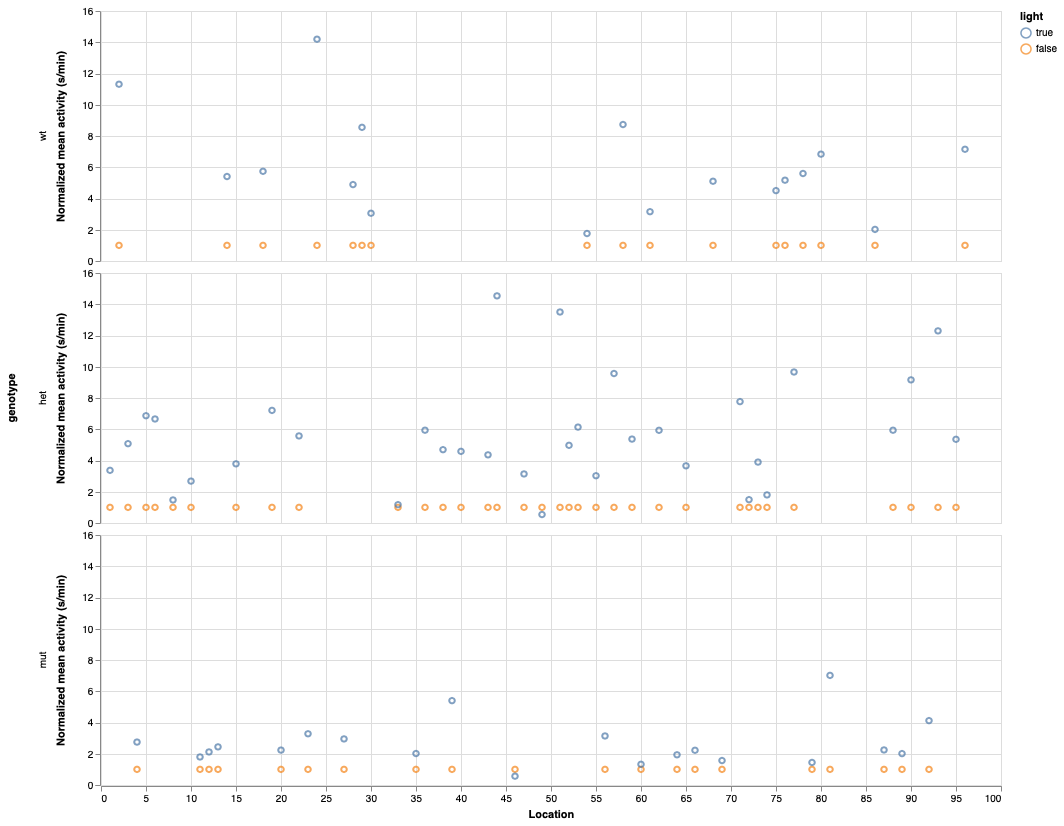

In [22]:
# Plot the normalized mean activity for each location through light/dark cycle
alt.Chart(df_mean, height=250, width=900
         ).mark_point(
         ).encode(
             x=alt.X('location:Q', title='Location'),
             y=alt.Y('norm_mean_activity:Q', title='Normalized mean activity (s/min)'),
             color=alt.Color('light:N', sort=[True, False]),
             row=alt.Row('genotype:N', sort=['wt', 'het', 'mut'])
         )

We can see that the mutant fishes have smaller normalized mean activities during the day, meaning that they are more active at night that the wild type or heterozygous zebrafish. 

Now let's plot the ECDF of the normalized mean activity.

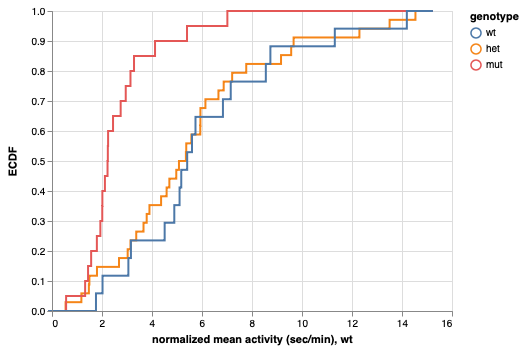

In [23]:
altcat.catplot(data=df_mean.loc[df_mean['light']==True, :],
               mark='line',
               encoding=dict(x=alt.X('norm_mean_activity:Q', 
                                     scale=alt.Scale(domain=[0,16]),
                                     title='normalized mean activity (sec/min), wt'),
                             color=alt.Color('genotype:N', sort=['wt', 'het', 'mut'])),
               transform = 'ecdf')

From the ECDF, we see that there is a greater percentage of mutant zebrafish with smaller normalized mean activity at all times compared to the wild-type and heterozygous fish. The ECDF indicates that the mutant fish are more active at night compared to the wild-type and heterzygotes, suggesting that they are not sleeping as well.

It may be more intuitive to be normalizing the activity at night by the activity during the day. In this case, a greater normalized mean activity would indicate more activity at night. We can do a check to see if we normalized the data differently, by dividing each fish's activity at night by their activity during the day, how the ECDF would look.

In [24]:
# Normalize day and night activity
norm_day_activity = np.divide(day_activity, day_activity)
norm_night_activity = np.divide(night_activity, day_activity)

In [25]:
df_mean.loc[df_mean['light']==True, 'norm_mean_activity_by_day'] = norm_day_activity
df_mean.loc[df_mean['light']==False, 'norm_mean_activity_by_day'] = norm_night_activity

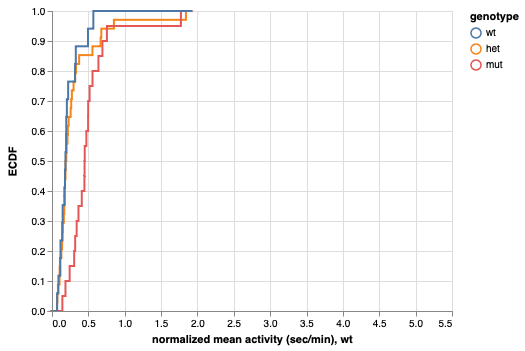

In [26]:
altcat.catplot(data=df_mean.loc[df_mean['light']==False, :],
               mark='line',
               encoding=dict(x=alt.X('norm_mean_activity_by_day:Q', 
                                     scale=alt.Scale(domain=[0,5.5]),
                                     title='normalized mean activity (sec/min), wt'),
                             color=alt.Color('genotype:N', sort=['wt', 'het', 'mut'])),
               transform = 'ecdf')

In this case, since a larger normalized mean activity means more activity at night, we see the same trend. The mutant fish are more active at night than the wild-type and heterogenous zebrafish.

## Second Parameter
Key Word: Sleep Bouts, Median Activity (each fish and whole population)

#### First, we want to look at the median activity of each genotype (whole population level), so we caculate the median activity of all the fish for each genotype at every timepoint

In [40]:
# Calculate the median activity for each genotype 
median_df = df.groupby(['genotype', 'zeit_ind']).median().reset_index()

#get rid of location column which is irrelevant
del median_df['location']

median_df = median_df.sort_values(by=['genotype', 'zeit_ind'])

median_df.head()

,genotype,zeit_ind,activity,zeit,day,light
0,het,-869,0.0,-14.480833,4,True
1,het,-868,0.0,-14.464167,4,True
2,het,-867,0.0,-14.447500,4,True
3,het,-866,0.0,-14.430833,4,True
4,het,-865,0.0,-14.414167,4,True


We could see the data has several days, but sleep is actually relevant to aging, according to the paper and other literature, it's not good to summarize across days, and day5 is always the choice of zebrafish community, so we just extract day5

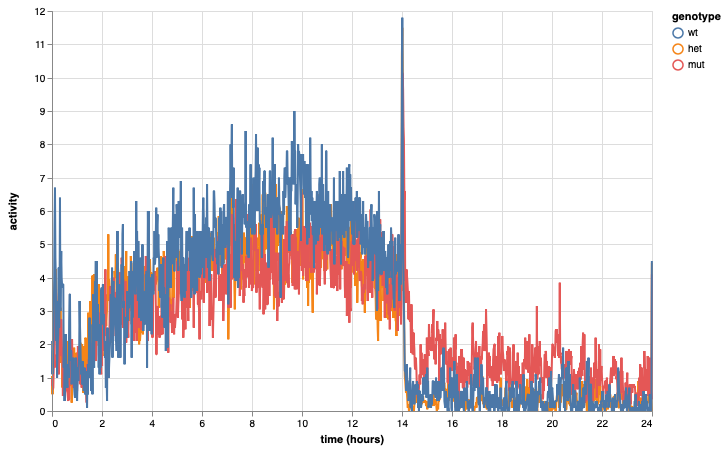

In [80]:
# Only extract the data of day5 (which is the agreement among zebrafish community)

inds = median_df['day'] == 5

alt.Chart(median_df.loc[inds,:], height = 400, width = 600
    ).mark_line(
        strokeJoin='bevel'
    ).encode(
        x=alt.X('zeit:Q', title='time (hours)'),
        y=alt.Y('activity:Q'),
        color=alt.Color('genotype:N', sort=['wt', 'het', 'mut']),
        order='zeit:Q'
    )

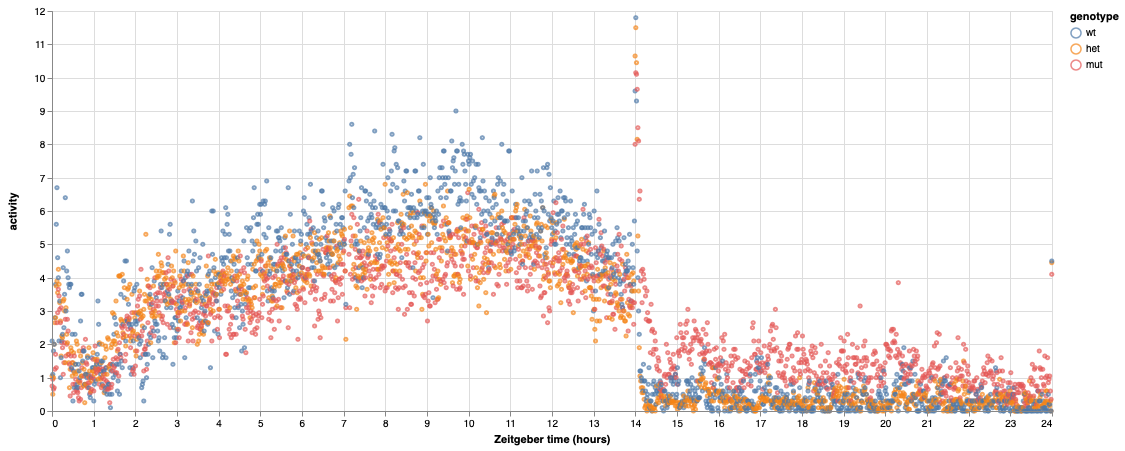

In [76]:
alt.Chart(median_df.loc[median_df['day']==5, :], 
          height=400, 
          width=1000
         ).mark_point(
            size=10
         ).encode(
             x=alt.X('zeit:Q', title='Zeitgeber time (hours)'),
             y=alt.Y('activity:Q'),
             color=alt.Color('genotype:N', sort=['wt', 'het', 'mut']),
             order = 'zeit:Q'
         )       

From this plot, we could see the general activity (median activity) at day5 of mut is higher than het and wt at night (hour14-22)

### To better quantify the real 'sleep period', we try to define a sleep bout. 

In the paper, they defined resting bout as below:
'Any 1 min bin with zero detectable movement was considered 1 min of rest, a rest bout was defined as a continuous string of rest minutes'
And we decide to defined a sleep bout as 2 consecutive minutes of resting (<0.2sec/2min)
We use 0.2 instead of 0 to avoid some noise generated from detection machine 

First, let's see the average sleep bouts of each genotype in Day5 using whole-population activity. 
We use 2minutes window in rolling to get the activity in 2 minutes interval

In [54]:
# Create GroupBy object
grouped = median_df.groupby('genotype')['zeit_ind', 'activity']

# we difine sleep bouts based on activity in 2 minutes, so make a RollingGroupby with window size of 2.
rolling = grouped.rolling(window=2, on='zeit_ind')

# sum each 2 minutes' activity
median_df_rolling = rolling.sum()

# Take a look
median_df_rolling = median_df_rolling.reset_index(level=0)
median_df_rolling.head()

,genotype,zeit_ind,activity
0,het,-869,NaN
1,het,-868,0.0
2,het,-867,0.0
3,het,-866,0.0
4,het,-865,0.0


In [55]:
#put the 2 minutes' rolling activity back to the original dataframe
median_df['rolling_activity (sec/2min)'] = median_df_rolling['activity']

median_df.loc[median_df['day'] == 5].head()

,genotype,zeit_ind,activity,zeit,day,light,rolling_activity (sec/2min)
869,het,0,1.05,0.002500,5,True,2.10
870,het,1,0.50,0.019167,5,True,1.55
871,het,2,1.00,0.035833,5,True,1.50
872,het,3,2.00,0.052500,5,True,3.00
873,het,4,2.65,0.069167,5,True,4.65


Then we need to add a sleep bout column to the dataframe based on the rolling_activity using our definition of sleep bout (<0.2sec/2min)

In [57]:
# define a function that use the condion of 2minutes of no movement to generate a new column
# if it's a sleep bout, then returns 1
def label_sleep_bout(c):
    if c['rolling_activity (sec/2min)'] < 0.2:
        return 1
    else:
        return 0

In [58]:
# add the sleep bout column
median_df['sleep'] = median_df.apply(label_sleep_bout, axis = 1)
median_df.loc[median_df['day']==5].head()

,genotype,zeit_ind,activity,zeit,day,light,rolling_activity (sec/2min),sleep
869,het,0,1.05,0.002500,5,True,2.10,0
870,het,1,0.50,0.019167,5,True,1.55,0
871,het,2,1.00,0.035833,5,True,1.50,0
872,het,3,2.00,0.052500,5,True,3.00,0
873,het,4,2.65,0.069167,5,True,4.65,0


In [59]:
# Caculate the number of sleep bout for each genotype at day5
sleep = median_df.loc[median_df['day']==5].groupby(['genotype', 'light']).sum()
sleep

zeit_ind  activity          zeit   day  \
genotype light                                           
het      False    684300    239.40  11401.666667  3000   
         True     351518   3358.30   5857.398889  4185   
mut      False    684300    850.45  11401.666667  3000   
         True     351518   3003.50   5857.398889  4185   
wt       False    684300    278.40  11401.666667  3000   
         True     351518   3892.90   5857.398889  4185   

                rolling_activity (sec/2min)  sleep  
genotype light                                      
het      False                       485.00     74  
         True                       6707.00      0  
mut      False                      1704.80      0  
         True                       6000.25      0  
wt       False                       561.90    121  
         True                       7777.20      0

Using our definition of sleep bout (rolling activity < 0.2sec/2min), we could see at day5, the mutant has zero sleep bout while the wt and het has a lot

But looking at the popultion-level of each genotype could prevent us from seeing the distrubution and details of each individual fish

So we decide to go ahead and see how many sleep bouts each individual fish has at day5

In [60]:
# for individual fish, need to go to the original df, and do the similar operation on it as on the population-level 
df.head()

,location,activity,time,zeit,zeit_ind,day,genotype,light
0,1,0.6,2013-03-15 18:31:09,-14.480833,-869,4,het,True
1,1,1.9,2013-03-15 18:32:09,-14.464167,-868,4,het,True
2,1,1.9,2013-03-15 18:33:09,-14.447500,-867,4,het,True
3,1,13.4,2013-03-15 18:34:09,-14.430833,-866,4,het,True
4,1,15.4,2013-03-15 18:35:09,-14.414167,-865,4,het,True


In [63]:
# Do the similar rolling for 2 minutes on df for each location
grouped1 = df.groupby('location')['zeit_ind', 'activity']

# Make a RollingGroupby with window size of 2.
rolling1 = grouped1.rolling(window=2, on='zeit_ind')

# sum the 2 minutes of acitivity
df_rolling = rolling1.sum()

# Look at rolling result
df_rolling = df_rolling.reset_index(level=0)
df_rolling.head()

,location,zeit_ind,activity
0,1,-869,NaN
1,1,-868,2.5
2,1,-867,3.8
3,1,-866,15.3
4,1,-865,28.8


In [64]:
# add the rolling result back to df
df['rolling_activity (sec/2min)'] = df_rolling['activity']
df.head()

,location,activity,time,zeit,zeit_ind,day,genotype,light,rolling_activity (sec/2min)
0,1,0.6,2013-03-15 18:31:09,-14.480833,-869,4,het,True,NaN
1,1,1.9,2013-03-15 18:32:09,-14.464167,-868,4,het,True,2.5
2,1,1.9,2013-03-15 18:33:09,-14.447500,-867,4,het,True,3.8
3,1,13.4,2013-03-15 18:34:09,-14.430833,-866,4,het,True,15.3
4,1,15.4,2013-03-15 18:35:09,-14.414167,-865,4,het,True,28.8


In [65]:
# use same definition of sleep bout to add sleep bout column
df['sleep'] = df.apply(label_sleep_bout, axis = 1)
df.head()

,location,activity,time,zeit,zeit_ind,day,genotype,light,rolling_activity (sec/2min),sleep
0,1,0.6,2013-03-15 18:31:09,-14.480833,-869,4,het,True,NaN,0
1,1,1.9,2013-03-15 18:32:09,-14.464167,-868,4,het,True,2.5,0
2,1,1.9,2013-03-15 18:33:09,-14.447500,-867,4,het,True,3.8,0
3,1,13.4,2013-03-15 18:34:09,-14.430833,-866,4,het,True,15.3,0
4,1,15.4,2013-03-15 18:35:09,-14.414167,-865,4,het,True,28.8,0


In [67]:
# summarize the number of sleep bouts for each location (each fish) at day5
sleep_each = df.loc[df['day']==5].groupby(['location','genotype', 'light']).sum().reset_index()
sleep_each.head()

,location,genotype,light,activity,zeit,zeit_ind,day,rolling_activity (sec/2min),sleep
0,1,het,False,725.8,11401.666667,684300,3000,1457.4,80
1,1,het,True,3411.5,5857.398889,351518,4185,6812.5,71
2,2,wt,False,325.5,11401.666667,684300,3000,656.1,241
3,2,wt,True,5136.6,5857.398889,351518,4185,10264.3,8
4,3,het,False,310.5,11401.666667,684300,3000,627.3,300


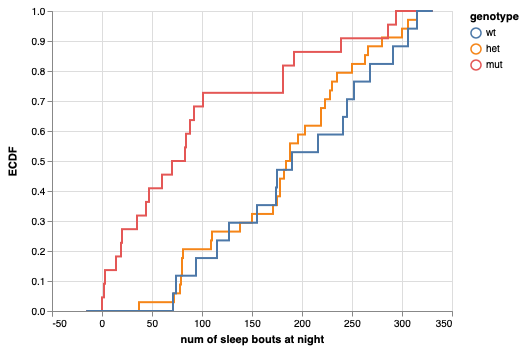

In [79]:
# Plot the ECDF for number of sleep bouts for each fish

# we want to look at the sleep bout at night
p1 = altcat.catplot(data= sleep_each.loc[sleep_each['light'] == False, :],
               mark='line',
               encoding=dict(x=alt.X('sleep:Q',
                                     title='num of sleep bouts at night'),
                             color=alt.Color('genotype:N', sort=['wt', 'het', 'mut'])),
               transform='ecdf')

p1


We could see most fish in mutant has less sleep bouts at night than the wt and het.